In [63]:
'''
Comparing single layer MLP with deep MLP (using TensorFlow)
'''
from scipy.optimize import minimize
import numpy as np
import pickle
from math import sqrt 

# Do not change this
def initializeWeights(n_in,n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
                            
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1);
    W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon;
    return W


# Replace this with your sigmoid implementation
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def nnObjFunction(params, *args):
    # Unpack arguments
    n_input, n_hidden, n_class, training_data, training_label, lambda_ = args

    # Reshape params into weight matrices w1 and w2
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))  # Hidden layer weights
    w2 = params[n_hidden * (n_input + 1):].reshape((n_class, (n_hidden + 1)))  # Output layer weights
    
    m = training_data.shape[0]

    # Forward propagation with bias terms
    x_bias = np.hstack((np.ones((m, 1)), training_data))  # Add bias to input layer
    
    # Hidden layer activations
    pre_hidden = x_bias.dot(w1.T)  # Shape: (m, n_hidden)
    post_hidden = sigmoid(pre_hidden)  # Shape: (m, n_hidden)
    
    # Add bias to hidden layer activations
    hidden_bias = np.hstack((np.ones((m, 1)), post_hidden))  # Shape: (m, n_hidden + 1)
    
    pre_output = hidden_bias.dot(w2.T) 
    post_output = sigmoid(pre_output)  

    y_encoding = np.zeros((m, n_class)) 
    y_encoding[np.arange(m), training_label] = 1  # Set correct class to 1

    loss = -np.sum(y_encoding * np.log(post_output + 1e-10) + (1 - y_encoding) * np.log(1 - post_output + 1e-10)) / m


    regularization = (lambda_ / (2 * m)) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))


    objective_val = loss + regularization

    # Backpropagation for gradients
    d_output = post_output - y_encoding  # Error at output layer (Shape: m x 2)
    
    gradient_W2 = (d_output.T.dot(hidden_bias) / m) + (lambda_ * np.hstack((np.zeros((n_class, 1)), w2[:, 1:]))) / m

    d_hidden = d_output.dot(w2[:, 1:]) * post_hidden * (1 - post_hidden)  
    
    gradient_W1 = (d_hidden.T.dot(x_bias) / m) + (lambda_ * np.hstack((np.zeros((n_hidden, 1)), w1[:, 1:]))) / m

    objective_gradient = np.concatenate([gradient_W1.flatten(), gradient_W2.flatten()])

    return objective_val, objective_gradient

# Replace this with your nnPredict implementation
def nnPredict(w1, w2, data):
    m = data.shape[0]  # Number of examples
    bias_x = np.hstack((np.ones((m, 1)), data))  # Add bias to input data
    
    # Forward propagation to the hidden layer
    pre_hidden = bias_x.dot(w1.T)
    post_hidden = sigmoid(pre_hidden)
    
    # Add bias to the hidden layer output
    hidden_bias = np.hstack((np.ones((m, 1)), post_hidden))  # Add bias to hidden layer output
    
    # Forward propagation to the output layer (sigmoid for binary classification)
    pre_output = hidden_bias.dot(w2.T)
    post_output = sigmoid(pre_output)  # This will be a matrix of shape (m, 2) for binary classification
    
    # Convert the output probabilities into binary predictions (0 or 1)
    predictions = np.argmax(post_output, axis=1)  # Get the class with the highest probability
    
    return predictions



# Do not change this
def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = labels[0]
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

In [65]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()


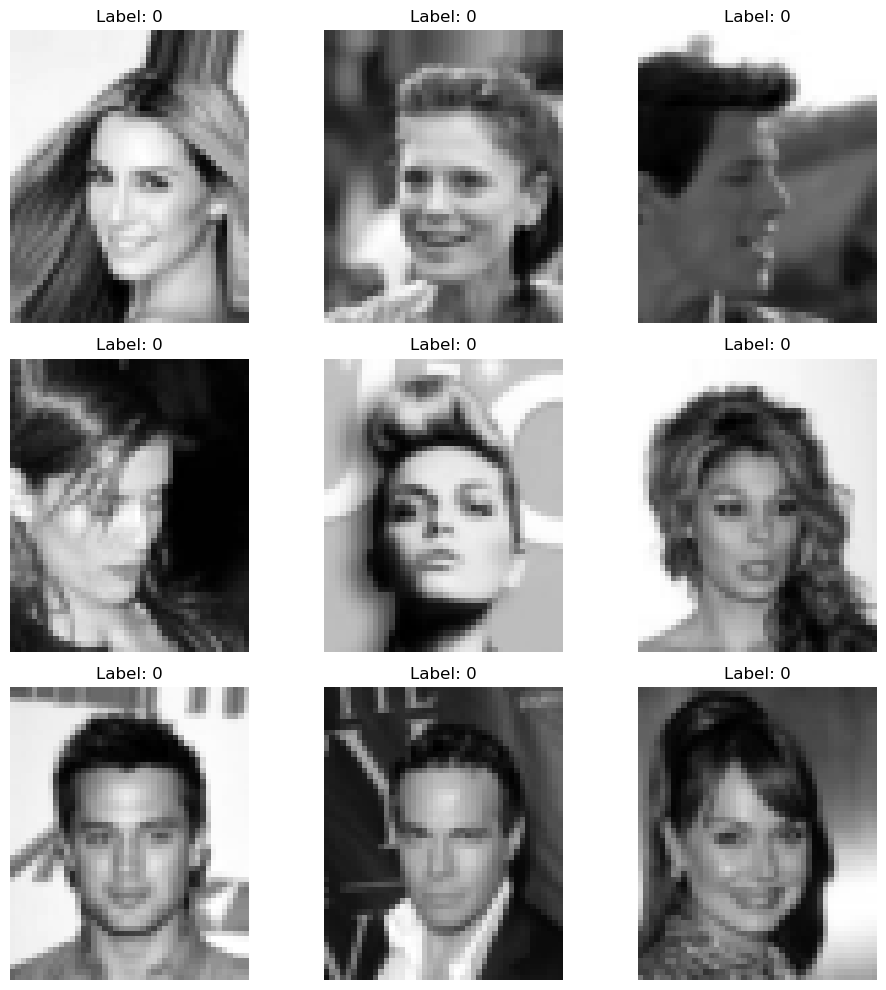

In [67]:
import matplotlib.pyplot as plt

def plt_images(images, labels, num_images=5):
    """Plot a grid of images."""
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(images[i].reshape(54, 44), cmap='gray')  # Reshape if needed
        plt.title(f"Label: {labels[i]}")  # Display the label
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

# Visualize some images from the training set
plt_images(train_data, train_label, num_images=9)

In [ ]:
#  Train Neural Network
# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]
# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 256
# set the number of nodes in output unit
n_class = 2

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden);
initial_w2 = initializeWeights(n_hidden, n_class);
# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()),0)
# set the regularization hyper-parameter
lambdaval = 0.02;
args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

#Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example
opts = {'maxiter' :50}    # Preferred value.

nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args,method='CG', options=opts)
params = nn_params.get('x')
#Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = params[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

In [ ]:
print(f"w1: {w1.shape}")
print(f"w2: {w2.shape}")

In [ ]:
#Test the computed parameters
predicted_label = nnPredict(w1,w2,train_data)
print(f"Shape of predicted_label: {predicted_label.shape}")
print(f"Shape of train_label: {train_label.shape}")

In [ ]:
print('\n CelebA dataset')
print('\n Training set Accuracy:' + str(100*np.mean((predicted_label == train_label).astype(float))) + '%')
predicted_label = nnPredict(w1,w2,validation_data)
print('\n Validation set Accuracy:' + str(100*np.mean((predicted_label == validation_label).astype(float))) + '%')
predicted_label = nnPredict(w1,w2,test_data)
print('\n Test set Accuracy:' +  str(100*np.mean((predicted_label == test_label).astype(float))) + '%')

In [ ]:
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a grid for subplots
        plt.imshow(images[i].reshape(54, 44), cmap='gray')  # Reshape if necessary
        plt.title(f"True: {true_labels[i]} Pred: {predicted_labels[i]}")
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

# Visualize some predictions
plot_predictions(test_data, test_label, predicted_label, num_images=9)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Experiment parameters
lambdas = np.arange(0, 61, 10)  # Regularization strengths to test
n_hidden = 8  # Fixing hidden units for this experiment
val_accuracies_lambda = []  # List to store validation accuracies for each λ

# Loop over different λ values
for lambda_val in lambdas:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Define arguments for optimization
    args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
    
    # Train the neural network
    start_time = time.time()
    opts = {'maxiter': 50}  # Maximum iterations
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    training_time = time.time() - start_time
    
    # Extract optimized weights
    params = nn_params.get('x')
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # Make predictions on validation set
    predicted_labels = nnPredict(w1, w2, validation_data)
    
    # Calculate accuracy on validation set
    accuracy = np.mean(predicted_labels == validation_label)

    # str(100*np.mean((predicted_labels == validation_label).astype(float)))
    # str(100*np.mean((predicted_label == train_label).astype(float)))
    # Append the accuracy for this λ value
    val_accuracies_lambda.append(accuracy)
    print(f"λ={lambda_val}, Validation Accuracy: {100*accuracy}" + "%")
    # print('\n Training set Accuracy:' + str(100*np.mean((predicted_label == train_label).astype(float))) + '%')
    
# Plot λ vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(lambdas, val_accuracies_lambda, marker='o', color='b')
plt.title("Regularization (λ)")
plt.xlabel("λ (Regularization Strength)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


In [ ]:
hidden_units_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]  # Different numbers of hidden units
train_times_hidden = []  # List to store training times
val_accuracies_hidden = []  # List to store validation accuracies for each hidden unit size

# Fixed λ for this experiment
lambda_val = 10

# Loop over different numbers of hidden units
for n_hidden in hidden_units_list:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    
    # Define arguments for optimization
    args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
    
    # Measure training time and train the network
    start_time = time.time()
    opts = {'maxiter': 50}  # Maximum iterations
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    training_time = time.time() - start_time
    
    # Extract optimized weights
    params = nn_params.get('x')
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # Make predictions on validation set
    predicted_labels = nnPredict(w1, w2, validation_data)
    
    # Calculate accuracy on validation set
    accuracy = np.mean(predicted_labels == validation_label)
    
    # Store results
    train_times_hidden.append(training_time)
    val_accuracies_hidden.append(accuracy)
    print(f"Hidden Units={n_hidden}, Validation Accuracy: {accuracy}, Training Time: {training_time:.2f}s")

# Plot training time vs number of hidden units
plt.figure(figsize=(8, 6))
plt.plot(hidden_units_list, train_times_hidden, marker='o', color='r')
plt.title("Training Time vs Number of Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.show()

# Plot validation accuracy vs number of hidden units
plt.figure(figsize=(8, 6))
plt.plot(hidden_units_list, val_accuracies_hidden, marker='o', color='g')
plt.title("Validation Accuracy vs Number of Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

In [ ]:
import pickle

params = {
    'selected_features': train_data,
    'optimal_n_hidden': n_hidden,
    'w1': w1,
    'w2': w2,
    'optimal_lambda': lambda_val
}

with open('params.pickle', 'wb') as f:
    pickle.dump(params, f)

print("Successfully saved to params.pickle.")


In [ ]:
import pickle

# Open the pickle file in read-binary mode
with open('params.pickle', 'rb') as f:
    params = pickle.load(f)

# Access the parameters
selected_features = params['selected_features']
optimal_n_hidden = params['optimal_n_hidden']
w1 = params['w1']
w2 = params['w2']
optimal_lambda = params['optimal_lambda']

# Print or use the parameters
print("*************************************************************************")
print("Selected Features:")
print("*************************************************************************")
print(selected_features)
print("*************************************************************************")
print("Optimal Hidden Units:")
print("*************************************************************************")
print(optimal_n_hidden)
print("*************************************************************************")
print("Weights from input to hidden layer (w1):")
print("*************************************************************************")
print(w1)
print("*************************************************************************")
print("Weights from hidden to output layer (w2):")
print("*************************************************************************")
print(w2)
print("*************************************************************************")
print("Optimal Regularization Lambda:")
print("*************************************************************************")
print(optimal_lambda)
